In [4]:
from SpecGP import means

In [38]:
x = np.linspace(0, 10, 100)

A = [1, 2, 3, 4, 5]
B = [5, 5, 5, 5, 10]
m = means.ConstantMean(5, C = A)
y = m.evaluate(x)

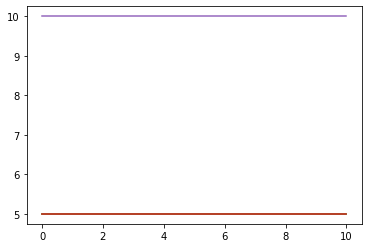

In [37]:
import matplotlib.pyplot as pl
%matplotlib inline
pl.plot(x, y.T)

In [ ]:
d = f(S=2, F = 4)

In [ ]:
for k, v in d.items():
    print(k, v)

In [ ]:
A = 1
A = np.array([1, 2, 3])

In [ ]:
A[:, None] * np.linspace(0, 10, 10)

In [ ]:
d

In [ ]:
A = [1, 2.0, 3, 4.0]
np.full(3, A)

In [ ]:
class Test:
    
    def __init__(self, nw=1, **kwargs):
        self.nw=nw
        for k, v in kwargs.items():
            setattr(self, k, v)

In [ ]:
t = Test(nw=2, C=3)

In [ ]:
t.C